<a href="https://colab.research.google.com/github/TombCrawler/nihonAI/blob/main/Nov1stMiniGen.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Nov１st 教授emailより：簡単で構いませんので、メロディデータに対して、
数個の音符列を入力すると、その次の音符を予測する
というモデルをTensorFlowで作る

In [ ]:
!pip install midi2audio
!apt install fluidsynth
!pip install pretty_midi
!pip install mido


In [ ]:
!pip list | grep jax

jax                              0.4.20
jaxlib                           0.4.20+cuda11.cudnn86


In [ ]:
!pip install -U jax jaxlib

In [ ]:
import random
import os
import glob

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.axes3d import Axes3D

import pretty_midi
import IPython.display as ipd
from midi2audio import FluidSynth
from music21 import *

import tensorflow as tf
from sklearn.model_selection import train_test_split
import tensorflow_probability as tfp
import keras
from keras import layers

import mido
from mido import MidiFile, MidiTrack, Message

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Here trying to convert MIDI file to a numpy array, partially [referred](https://medium.com/analytics-vidhya/convert-midi-file-to-numpy-array-in-python-7d00531890c) but eventually failed


In [ ]:
class UnsupportedMidiFileException(Exception):
  "Unsupported MIDI File"

In [ ]:
# nn_from: the lowest pitch(including this number)
# nn_thru: the heighest pitch (Excluding this number)
# seqlen: the element towards time axis, turn out to be the number of measure. If you give 64 to seqlen based on eighth note, it has 8 measures
#       The song's length(pianoroll.shape[1] must be longer than 64)
# tempo: tempo
def get_pianoroll(midi, nn_from, nn_thru, seqlen, tempo):
  pianoroll = midi.get_piano_roll(fs=2*tempo/60)
  print(f"seqlen!!{seqlen}")
  print(f"piano_roll.shape[1] a.k.a song length!{pianoroll.shape[1]}")
  if pianoroll.shape[1] < seqlen:
    raise UnsupportedMidiFileException
  pianoroll = pianoroll[nn_from:nn_thru, 0:seqlen]
  pianoroll = np.heaviside(pianoroll, 0)
  return np.transpose(pianoroll)

In [ ]:
# add rest nodes to the binary piano roll matrix to make the one-hot representation function

# add rest nodes
def add_rest_nodes(pianoroll):
  # make a "rest node series"
  # If all the elemets are zero, the rest node says 1, else 0
  print(f"pinoroll!\n{pianoroll}")
  rests = 1 - np.sum(pianoroll, axis=1)
  print(f"rests!\n{rests}")

  # Make the "rest node series" a 2D array. To use it as a matrix, it's reshaped into a 2D array with a single column.
  rests = np.expand_dims(rests, 1)
  print(f"2D rests!\n{rests}")
  print(f"concatenated!\n{np.concatenate([pianoroll, rests], axis=1)}")
  # Concatenate the binary pianoroll matrix and the rest node series matrix and return it
  return np.concatenate([pianoroll, rests], axis=1)

In [ ]:
def read_midi(filename, sop_alto, seqlen):
  # read midi file
  midi = pretty_midi.PrettyMIDI(filename)

  # An Exception error is thrown if there is a modulation(key change)
  if len(midi.key_signature_changes) !=1:
    raise UnsupportedMidiFileException

  # Modulate the given key to C major or C minor
  key_number = midi.key_signature_changes[0].key_number
  # transpose_to_c(midi, key_number)

  # Get Major key(keynode=0) or Minor key(keynode=1)
  # key_number has values ​​from 0 to 11 for major keys and for minor keys,
  # 12~23 is included, so by dividing it by 12 and converting it to an integer,
  # it will be 0 if it is a major key,
  # If it is a minor key, we find the value 1 and assign it to keymode.
  keymode = np.array([int(key_number / 12)])

  # The Exception error thrown when tempo changes
  tempo_time, tempo = midi.get_tempo_changes()
  print(f"tempo_changes{midi.get_tempo_changes()}")
  print(f"tempo_time{tempo_time}, tempo{tempo}")
  if len(tempo) != 1: # counting the number of elements in the tempo array
    raise UnsupportedMidiFileException

  if sop_alto: # The argument is coming in as boolean, True or False
    # The exception thrown if there are less than 2 parts
    if len(midi.instruments) < 2:
      raise UnsupportedMidiFileException

    # Get pianoRoll binary Matrix for each of Soprano and alto parts
    pr_s = get_pianoroll(midi.instruments[0], 36, 84, seqlen, tempo[0])
    pr_a = get_pianoroll(midi.instruments[1], 36, 84, seqlen, tempo[0])
    pr_b = get_pianoroll(midi.instruments[2], 36, 84, seqlen, tempo[0])

    # return pr_s, pr_a, keymode
    return pr_s, pr_a, pr_b, keymode

  else:
    # Get a pianoroll which gathered all the parts
    pr = get_pianoroll(midi, 36, 84, seqlen, tempo[0])
    return pr, keymode

In [ ]:
# code 4.3, prepare MIDI data for the model
# set the path for the MIDI file
dir = "drive/MyDrive/chorales/midi/"

x_all = [] # the list which stores inputs of soprano melodies
y_all = [] # the list which stores outputs of alto melodies
keymodes = [] # the list which stores the key whether it is major or minor
files = [] # stores the filenames of the MIDI files

# repeat the process with all the midi files
for f in glob.glob(dir + "/*.mid"):
  print(f)
  try:
    # pr_s is for soprano pianoroll, pr_a is for alto, keymode is for either major 0 or minor 1
    # pr_s, pr_a, keymode = read_midi(f, True, 64)
    pr_s, pr_a, pr_b, keymode = read_midi(f, True, 64)
    # add rests to the pianoroll
    x = add_rest_nodes(pr_s)
    y = add_rest_nodes(pr_a)
    # x = add_rest_nodes(pr_b)
    # y = add_rest_nodes(pr_a)

    # add pianorolls which have been added rest elements to the lists
    x_all.append(x)
    y_all.append(y)
    keymodes.append(keymode)
    files.append(f)
  # throw exception for midi data which can not be  used
  except UnsupportedMidiFileException:
    print("skip")
# convert x_all and y_all into NumPy array to make them more useful later
x_all = np.array(x_all)
y_all = np.array(y_all)

In [ ]:
# apply half of the data you stored for training data, and the other half for test data
# the ratio should be 1:1
i_train, i_test = train_test_split(range(len(x_all)),
                                   test_size=int(len(x_all)/2),
                                   shuffle=False)
x_train = x_all[i_train]
x_test = x_all[i_test]
y_train = y_all[i_train]
y_test = y_all[i_test]

In [ ]:
# Make a model here (LSTM), referred the code 5.1 from the prof book
# code 5.1- implementation of encoder

seq_length = x_train.shape[1] # time length
input_dim = x_train.shape[2] # the number of input dimension
encoded_dim = 16 # the number of vectors you want to compress into
lstm_dim = 1024 # The book's suggested value is 1024. the number of RNN(LSTM) layers' hidden node.

# make an empty model as an encoder part
encoder = tf.keras.Sequential()

# add RNN(LSTM) layers to the model
# return_sequence=Flase means it only returns t he last time vector's value
encoder.add(tf.keras.layers.LSTM(
    lstm_dim, input_shape=(seq_length, input_dim),
    use_bias=True, activation="tanh", return_sequences=False
    ))
#add output layers (encoded_dim will be the number o nodes)
encoder.add(tf.keras.layers.Dense(
    encoded_dim, use_bias=True, activation="linear"
))
# display the model
encoder.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1024)              4399104   
                                                                 
 dense (Dense)               (None, 16)                16400     
                                                                 
Total params: 4415504 (16.84 MB)
Trainable params: 4415504 (16.84 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# code 5.2- Implement decoder

#make an empty model
decoder = tf.keras.Sequential()
# Time-series by repeating input layer vectors to be able to add the later RNN(LSTM)
decoder.add(tf.keras.layers.RepeatVector(
    seq_length, input_dim=encoded_dim
  ))
# make LSTM layers and add them to the model
decoder.add(tf.keras.layers.LSTM(
    lstm_dim, use_bias=True, activation="tanh",
    return_sequences=True
    ))

# add output layers to the model. The number of nodes should equal the input's
# return_sequncces is True because decoder is a time-series
# use softmax because the output is one-hot vectors on every time stamps
decoder.add(tf.keras.layers.Dense(
    input_dim, use_bias=True, activation="softmax"
    ))
#display it
decoder.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 repeat_vector (RepeatVecto  (None, 64, 16)            0         
 r)                                                              
                                                                 
 lstm_1 (LSTM)               (None, 64, 1024)          4263936   
                                                                 
 dense_1 (Dense)             (None, 64, 49)            50225     
                                                                 
Total params: 4314161 (16.46 MB)
Trainable params: 4314161 (16.46 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# code 5.3- concatnate encoder and decoder to make an Auto-encoder
# check

# make a model
model = tf.keras.Model(encoder.inputs, decoder(encoder.outputs))

# compile the model
model.compile(optimizer="adam", loss="categorical_crossentropy",
              metrics="categorical_accuracy")
# dispay
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_input (InputLayer)     [(None, 64, 49)]          0         
                                                                 
 lstm (LSTM)                 (None, 1024)              4399104   
                                                                 
 dense (Dense)               (None, 16)                16400     
                                                                 
 sequential_1 (Sequential)   (None, 64, 49)            4314161   
                                                                 
Total params: 8729665 (33.30 MB)
Trainable params: 8729665 (33.30 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


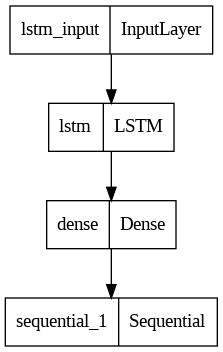

In [ ]:
keras.utils.plot_model(model, "my_first_model.png")

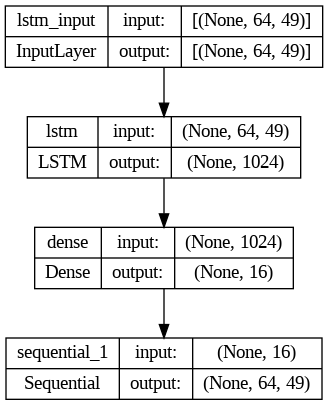

In [ ]:
keras.utils.plot_model(model, "my_first_model_with_shape_info.png", show_shapes=True)

In [ ]:
# code 5.4 - Train the model.
#the 1st and the 2nd arguments should be the same as input and output should be the same
model.fit(x_train, x_train, batch_size=32, epochs=100)

In [ ]:
# code 5.5
model.evaluate(x_test, x_test)

8/8 [==============================] - 1s 22ms/step - loss: 2.1541 - categorical_accuracy: 0.3091


[2.1541213989257812, 0.3090839982032776]

In [ ]:
# oA_ Load the MIDI file and convert it to a numpy array
input_midi_path = '/content/drive/MyDrive/chorales/combined_notes2.mid'
input_mid = mido.MidiFile(input_midi_path, clip=True)

midi_data = []

for track in input_mid.tracks:
   for msg in track:
     if msg.type == 'note_on' or msg.type == 'note_off':
         # extract relevant information from the MIDI event
         time = msg.time
         note = msg.note
         velocity = msg.velocity
         # 1 for note_on, 0 for note_off
         event_type = 1 if msg.type == 'note_on' else 0

         # Append the information as a tuple to the MIDI data list
         midi_data.append((time, note, velocity, event_type))

# convert the MIDI data list to a numpy array
midi_data_array = np.array(midi_data)
print(midi_data_array)

[[2880   60  100    1]
 [ 480   60    0    1]
 [   0   60  100    1]
 [ 480   60    0    1]]


In [ ]:
output_midi_path = '/content/drive/MyDrive/chorales/generated_note.mid'

In [ ]:
# failed code Nov 10th 2023

# # Function to preprocess input for prediction
# def preprocess_input(input_sequence, seq_length, input_dim):
#     # Assuming input_sequence has shape (time_steps, features)

#     # If input_dim is already correct, use it
#     if input_sequence.shape[1] == input_dim:
#         processed_input_sequence = input_sequence
#     else:
#         # Use only the first `input_dim` features
#         processed_input_sequence = input_sequence[:, :input_dim]

#     # If needed, pad or truncate the input sequence to match the expected sequence length
#     if processed_input_sequence.shape[0] < seq_length:
#         padding = np.zeros((seq_length - processed_input_sequence.shape[0], processed_input_sequence.shape[1]))
#         processed_input_sequence = np.vstack((processed_input_sequence, padding))
#     elif processed_input_sequence.shape[0] > seq_length:
#         processed_input_sequence = processed_input_sequence[:seq_length, :]

#     # Ensure the input sequence has the correct shape
#     processed_input_sequence = np.reshape(processed_input_sequence, (1, seq_length, input_dim))

#     return processed_input_sequence

# # Function to post-process model output
# def postprocess_output(output_sequence):
#     # Assuming the output_sequence is in the shape (batch_size, seq_length, output_dim)
#     # Extract the last time step of the output sequence
#     last_time_step = output_sequence[:, -1, :]

#     # Assuming the output_dim is the number of features in the output (e.g., note and velocity)
#     output_dim = last_time_step.shape[1]

#     # Reshape the last_time_step to (output_dim,)
#     last_time_step = np.reshape(last_time_step, (output_dim,))

#     # Denormalize the values if needed
#     # For example, if notes were normalized to [0, 1], you might multiply them by 127 to get MIDI note values
#     denormalized_notes = last_time_step[0] * 127.0  # Adjust this based on your normalization range
#     denormalized_velocities = last_time_step[1] * 127.0  # Adjust this based on your normalization range

#     # Assuming your output should be a tuple of (note, velocity)
#     predicted_note = (denormalized_notes, denormalized_velocities)

#     return predicted_note

# # Generate the next note (Using the trained model)
# def generate_next_note(model, input_sequence, seq_length, input_dim):
#     # Preprocess input for prediction
#     processed_input_sequence = preprocess_input(input_sequence, seq_length, input_dim)

#     # Use the model to predict the next note
#     next_note_sequence = model.predict(processed_input_sequence)

#     # Post-process output to get the predicted note
#     next_note = postprocess_output(next_note_sequence)

#     return next_note

# seq_length = 64  # Adjust this based on your model's expected sequence length
# input_dim = 2  # Assuming you're using note and velocity as input features

# # Assuming midi_data_array is your MIDI data in the format (time, note, velocity, event_type)
# next_note = generate_next_note(model, midi_data_array, seq_length, input_dim)

# print(next_note)


In [ ]:
# failed attempt 1

# # Extract the pitch of the first note from next_note
# next_note_scalar = int(next_note[0][0][0])

# # Create a PrettyMIDI object for the next note
# output_midi = pretty_midi.PrettyMIDI()
# instrument = pretty_midi.Instrument(0)

# # Add the next note to the instrument
# instrument.notes.append(pretty_midi.Note(
#     velocity=64, pitch=next_note_scalar, start=0, end=1
# ))

# # Add the instrument to the MIDI file
# output_midi.instruments.append(instrument)

# # Save the generated note as a new MIDI file
# output_midi.write(output_midi_path)


In [ ]:
# failed attempt 2

# def generate_midi_from_notes(notes, output_path):
#     # Create a PrettyMIDI object
#     midi_data = pretty_midi.PrettyMIDI()

#     # Create an Instrument instance for the generated notes
#     instrument = pretty_midi.Instrument(0)

#     time = 0  # Initialize the time

#     # Iterate through the generated notes and create Note instances
#     for step in range(len(notes)):
#         for note_num, velocity in enumerate(notes[step]):
#             if velocity.any() > 0: # to check if any value is greater than 0

#                 # round the velocity to the nearest integer
#                 velocity = np.round(velocity).astype(int)

#                 # ensure the velocity is within the valid MIDI range(0-127)
#                 velocity = np.maximum(0, np.minimum(velocity, 127))

#                 # Create a Note instance for each active note
#                 note = pretty_midi.Note(velocity=velocity, pitch=note_num, start=time, end=time+1/32)  # Adjust the duration as needed
#                 instrument.notes.append(note)

#         # Increment the time by one time step
#         time += 1/32  # Adjust the time step as needed

#     # Add the instrument to the MIDI object
#     midi_data.instruments.append(instrument)

#     # Write the MIDI data to a file
#     print(output_path)
#     midi_data.write(output_path)

# # Generate the MIDI data from "next_note" and save it to a file
# generate_midi_from_notes(next_note, output_midi_path)

In [ ]:
# failed attempt 3

# def generate_midi_from_notes(notes, output_path):
#     # Create a PrettyMIDI object
#     midi_data = pretty_midi.PrettyMIDI()

#     # Create an Instrument instance for the generated notes
#     instrument = pretty_midi.Instrument(0)

#     time = 0  # Initialize the time

#     # Iterate through the generated notes and create Note instances
#     for step in range(len(notes)):
#         for note_num, velocity in enumerate(notes[step]):
#             if np.any(velocity > 0):  # Use np.any() to check if any value is greater than zero
#                 # Round the velocity to the nearest integer using np.round
#                 velocity = np.round(velocity).astype(int)

#                 # Ensure the velocity is within the valid MIDI range (0-127)
#                 velocity = np.maximum(0, np.minimum(velocity, 127))

#                 # Create a Note instance for each active note
#                 note = pretty_midi.Note(velocity=velocity, pitch=note_num, start=time, end=time+1/32)  # Adjust the duration as needed
#                 instrument.notes.append(note)

#         # Increment the time by one time step
#         time += 1/32  # Adjust the time step as needed

#     # Add the instrument to the MIDI object
#     midi_data.instruments.append(instrument)

#     # Write the MIDI data to a file
#     midi_data.write(output_path)


In [ ]:
# filed attempt 4

# def generate_midi_from_notes(notes, output_path):
#     # Create a PrettyMIDI object
#     midi_data = pretty_midi.PrettyMIDI()

#     # Create an Instrument instance for the generated notes
#     instrument = pretty_midi.Instrument(0)

#     time = 0  # Initialize the time

#     # Define a function to convert values in the range [0, 1] to MIDI velocities (0-127)
#     def velocity_to_midi(value):
#         return int(value * 127)

#     # Iterate through the generated notes and create Note instances
#     for step in range(len(notes)):
#         for note_num, velocity in enumerate(notes[step][0]):
#             if velocity > 0:  # Check if the velocity is greater than 0
#                 # Convert the value to MIDI velocity
#                 midi_velocity = velocity_to_midi(velocity)

#                 # Create a Note instance for each active note
#                 note = pretty_midi.Note(velocity=midi_velocity, pitch=note_num, start=time, end=time+1/32)  # Adjust the duration as needed
#                 instrument.notes.append(note)

#         # Increment the time by one time step
#         time += 1/32  # Adjust the time step as needed

#     # Add the instrument to the MIDI object
#     midi_data.instruments.append(instrument)

#     # Write the MIDI data to a file
#     midi_data.write(output_path)

# generate_midi_from_notes(next_note, output_midi_path)


In [ ]:
# Ambiguous function..

# oA_ ATTENTION! You may want to modify this function if you want to generate only one single note
# def create_sequence_from_midi(idi_data):
#   notes = []
#   for instrument in midi_data.instruments:
#     for note in instrument.notes:
#       notes.append((note.pitch, note.start))

#   # Sort the notes by start time
#   notes.sort(key=lambda x: x[1])

#   # Create a list of time intervals between notes
#   intervals = [notes[i+1][1] - notes[i][1] for i in range(len(notes)-1)]

#   return intervals
# note_intervals = create_sequence_from_midi(loaded_midi_data)

In [ ]:
# Ambiguous function..

# oA_ Load and preprocess the MIDI data
# def load_midi(file_path):
#   midi_data = pretty_midi.PrettyMIDI(file_path)
#   return midi_data

# loaded_midi_data = load_midi(input_midi_path)
# print(loaded_midi_data)